In [20]:
import pandas as pd
import numpy as np
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import everygrams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
  
ps = PorterStemmer()
stop = stopwords.words('english')
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [5]:
data_train = pd.read_csv("train.csv",encoding='utf-8')
data_test = pd.read_csv("test.csv",encoding='utf-8')

In [6]:
data_train = data_train.drop(['keyword','location'],axis=1)
data_test = data_test.drop(['keyword','location'],axis=1)

In [7]:
data_train['text'] = data_train['text'].str.lower()
data_train['text'] = data_train['text'].str.replace("[^\w\s]"," ")
data_train['text'] = data_train['text'].str.replace("[\d+]"," ")
for i in list("!@#$%^&*()[]{};:,./<>?\|`~-=_+"):
    data_train['text'] = data_train['text'].str.replace(i," ")    
    
data_train['text'] = data_train.apply(lambda row: tokenizer.tokenize(row['text']), axis=1)
data_train["text"] = data_train['text'].apply(lambda row : [i for i in row if i not in stop] )
data_train["text"] = data_train['text'].apply(lambda row : [lemmatizer.lemmatize(i) for i in row ] )
data_train["text"] = data_train['text'].apply(lambda row : [ps.stem(i) for i in row ] )
data_train["text"] = data_train['text'].apply(lambda row : " ".join(row))

data_test['text'] = data_test['text'].str.lower()
data_test['text'] = data_test['text'].str.replace("[^\w\s]"," ")
data_test['text'] = data_test['text'].str.replace("[\d+]"," ")
for i in list("!@#$%^&*()[]{};:,./<>?\|`~-=_+"):
    data_test['text'] = data_test['text'].str.replace(i," ")    
    
data_test['text'] = data_test.apply(lambda row: tokenizer.tokenize(row['text']), axis=1)
data_test["text"] = data_test['text'].apply(lambda row : [i for i in row if i not in stop] )
data_test["text"] = data_test['text'].apply(lambda row : [lemmatizer.lemmatize(i) for i in row ] )
data_test["text"] = data_test['text'].apply(lambda row : [ps.stem(i) for i in row ] )
data_test["text"] = data_test['text'].apply(lambda row : " ".join(row))

<ipython-input-7-5cffb75ec9ad>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_train['text'] = data_train['text'].str.replace("[^\w\s]"," ")
<ipython-input-7-5cffb75ec9ad>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data_train['text'] = data_train['text'].str.replace("[\d+]"," ")
<ipython-input-7-5cffb75ec9ad>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data_train['text'] = data_train['text'].str.replace(i," ")
<ipython-input-7-5cffb75ec9ad>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  data_test['text'] = data_test['text'].str.replace("[^\w\s]"," ")
<ipython-input-7-5cffb75ec9ad>:15: FutureWarning: The default value of regex will change from True to False in a fut

In [8]:
x_train,x_validation,y_train,y_validation = train_test_split(data_train['text'],data_train['target'],test_size=0.3)

In [147]:
from sklearn.pipeline import Pipeline
def accuracy_result(used_model,n_gram_range = (1,3)):
    print("({}-{})".format(n_gram_range[0],n_gram_range[1]))
    res = []
    vectorizer = TfidfVectorizer(ngram_range=n_gram_range)
    
    vectorizer.fit(x_train)
    total_features = len(vectorizer.get_feature_names())
    max_f = np.arange(0.1,1.01,0.1)
    
    for n in max_f:
#         vectorizer.set_params(ngram_range=n_gram_range,max_features = int(n * total_features))
        checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(ngram_range=n_gram_range,max_features = int(n * total_features))),
            ('classifier', used_model)
        ])
        model = checker_pipeline.fit(x_train,y_train)
        
        Y_pred = model.predict(x_validation)
        print(accuracy_score(y_validation, Y_pred))
        res.append((n*100,int(n * total_features),accuracy_score(y_validation, Y_pred)))
    return(res)
def unitrigram_accuracy_result(used_model):
    print("(1,3)")
    res = []
    check_vectorizer = CountVectorizer(ngram_range=(1,3)).fit(x_train)
    check2_vectorizer = CountVectorizer(ngram_range=(2,2)).fit(x_train)

    total_features = len(check_vectorizer.get_feature_names()) - len(check2_vectorizer.get_feature_names())
    max_f = np.arange(0.1,1.01,0.1)
    
    for n in max_f:
        tfidf_vectorizer = CountVectorizer(ngram_range=(1,3),max_features = int(n * total_features))
    #     tfidf_vectorizer_2 = CountVectorizer(ngram_range=(2,2))

        a = tfidf_vectorizer.fit_transform(x_train)
        b =  a.todense().tolist()
        c = pd.DataFrame(b,columns=tfidf_vectorizer.get_feature_names())
#         print(len(c.columns))
        selected_train_column = [sel_c for sel_c in c.columns if len(sel_c.split())!=2]
        c = c[selected_train_column]
#         print(len(c.columns))

        a2 = tfidf_vectorizer.transform(x_validation)
        b2 =  a2.todense().tolist()
        c2 = pd.DataFrame(b2,columns=tfidf_vectorizer.get_feature_names())
#         print(len(c2.columns))
        selected_validation_column = [sel_c for sel_c in c2.columns if len(sel_c.split())!=2]
        c2 = c2[selected_validation_column]
#         print(len(c2.columns))

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
        m_train = tfidf_transformer.fit_transform(c)
        v_train =  m_train.todense().tolist()

        m_validation = tfidf_transformer.transform(c2)
        v_validation =  m_validation.todense().tolist()
        model = used_model.fit(v_train,y_train)
        
        Y_pred = model.predict(v_validation)
        print(accuracy_score(y_validation, Y_pred))
        res.append((n*100,int(n * total_features),accuracy_score(y_validation, Y_pred)))
    return(res)


In [148]:

svm = SVC()

svm_plot_ubtgt = accuracy_result(svm,(1,3))
svm_plot_ubgt = accuracy_result(svm,(1,2))
svm_plot_ugt = accuracy_result(svm,(1,1))
svm_plot_utgt = unitrigram_accuracy_result(svm)
svm_plot_btgt = accuracy_result(svm,(2,3))
svm_plot_tgt = accuracy_result(svm,(3,3))
svm_plot_bgt = accuracy_result(svm,(2,2))

(1-3)
0.8069176882661997
0.8086690017513135
0.8012259194395797
0.7999124343257443
0.7942206654991243
0.792907180385289
0.7898423817863398
0.7867775831873906
0.781523642732049
0.7788966725043783
(1-2)
0.8060420315236427
0.8051663747810858
0.803415061295972
0.7999124343257443
0.7990367775831874
0.7964098073555166
0.7968476357267951
0.8003502626970228
0.7990367775831874
0.7950963222416813
(1-1)
0.7955341506129597
0.8029772329246935
0.8064798598949212
0.8047285464098074
0.8051663747810858
0.8016637478108581
0.8038528896672504
0.8021015761821366
0.803415061295972
0.803415061295972
(1,3)
0.8051663747810858
0.8060420315236427
0.8056042031523643
0.8060420315236427
0.803415061295972
0.7999124343257443
0.8025394045534151
0.7981611208406305
0.7972854640980735
0.7994746059544658
(2-3)
0.7469352014010507
0.75
0.7473730297723292
0.7451838879159369
0.7517513134851138
0.7057793345008757
0.7027145359019265
0.7044658493870403
0.7031523642732049
0.7005253940455342
(3-3)
0.702276707530648
0.71190893169877

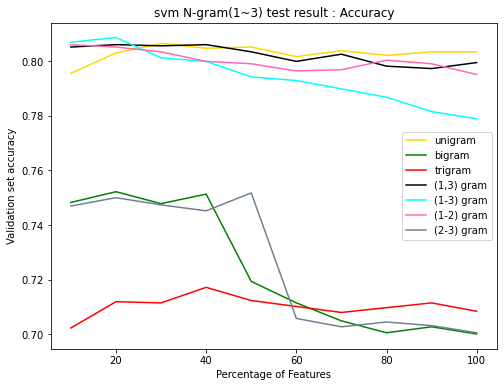

In [149]:
svm_nfeatures_plot_ugt = pd.DataFrame(svm_plot_ugt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_bgt = pd.DataFrame(svm_plot_bgt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_tgt = pd.DataFrame(svm_plot_tgt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_ubtgt = pd.DataFrame(svm_plot_ubtgt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_utgt = pd.DataFrame(svm_plot_utgt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_ubgt = pd.DataFrame(svm_plot_ubgt,columns=['data_percentage','nfeatures','validation_accuracy'])
svm_nfeatures_plot_btgt = pd.DataFrame(svm_plot_btgt,columns=['data_percentage','nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(svm_nfeatures_plot_ugt.data_percentage, svm_nfeatures_plot_ugt.validation_accuracy, label='unigram',color='gold')
plt.plot(svm_nfeatures_plot_bgt.data_percentage, svm_nfeatures_plot_bgt.validation_accuracy, label='bigram',color='green')
plt.plot(svm_nfeatures_plot_tgt.data_percentage, svm_nfeatures_plot_tgt.validation_accuracy, label='trigram',color='red')
plt.plot(svm_nfeatures_plot_utgt.data_percentage, svm_nfeatures_plot_utgt.validation_accuracy, label='unitrigram',color='black')
plt.plot(svm_nfeatures_plot_ubtgt.data_percentage, svm_nfeatures_plot_ubtgt.validation_accuracy, label='unibitrigram',color='cyan')
plt.plot(svm_nfeatures_plot_ubgt.data_percentage, svm_nfeatures_plot_ubgt.validation_accuracy, label='unibigram',color='hotpink')
plt.plot(svm_nfeatures_plot_btgt.data_percentage, svm_nfeatures_plot_btgt.validation_accuracy, label='bitrigram',color='slategray')
plt.title("svm N-gram(1~3) test result : Accuracy")
plt.xlabel("Percentage of Features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [150]:
best_gram_comp = []

def get_best_comp(plot,gram):
    best = 0
    percentage = 0
    nfeatures = 0
    for i in plot:
        if(i[2] > best):
            best = i[2]
            percentage = i[0]
            nfeatures = i[1]
        elif(i[2] == best):
            if(i[0] < percentage):
                best = i[2]
                percentage = i[0]
                nfeatures = i[1]
    best_gram_comp.append([gram,best,percentage,nfeatures])


get_best_comp(svm_plot_ubtgt,"1-3")
get_best_comp(svm_plot_ubgt,"1-2")
get_best_comp(svm_plot_ugt,"1-1")
get_best_comp(svm_plot_utgt,"1,3")
get_best_comp(svm_plot_btgt,"2-3")
get_best_comp(svm_plot_tgt,"3-3")
get_best_comp(svm_plot_bgt,"2-2")

pd.DataFrame(best_gram_comp,columns=["gram","accuracy","Feature Percentage","Total Features"])


,gram,accuracy,Feature Percentage,Total Features
0,1-3,0.808669,20.0,19268
1,1-2,0.806042,10.0,5510
2,1-1,0.806480,30.0,4435
3,"1,3",0.806042,20.0,11205
4,2-3,0.751751,50.0,40779
5,3-3,0.717163,40.0,16496
6,2-2,0.752189,20.0,8063


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectorizer.fit(x_train)
total_features = len(vectorizer.get_feature_names())

In [13]:
svm = SVC()
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features = int(total_features * 0.2))
train_vectors = vectorizer.fit_transform(x_train)
train_dense = train_vectors.todense().tolist()
svm.fit(train_dense,y_train)

SVC()

In [15]:
validation_vectors = vectorizer.transform(x_validation)
validation_dense = validation_vectors.todense().tolist()
svm_predict = svm.predict(validation_dense)

In [21]:
print(classification_report(y_validation,svm_predict,target_names=["Non Disaster","Disaster"]))
baseline_accuracy = accuracy_score(y_validation,svm_predict)

              precision    recall  f1-score   support

Non Disaster       0.78      0.90      0.84      1316
    Disaster       0.83      0.66      0.74       968

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [ ]:
params_svc = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear', 'ploy']}